<h1 style="text-align:center; font-size: 50px; margin: 0; font-weight: 300; margin-bottom: 5px">Exoplanets Homework 3 - Tom Wagg</h1>
<h3 style="text-align:center; font-size: 25px; font-style: italic; font-weight: 100; margin: 0; margin-bottom: 10px">It's TTV Time</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const

import rebound

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Contents
- [Problem 1](#p1)
- [Problem 2](#p2)
- [Problem 3](#p3)
- [Problem 4](#p4)

<h1><a id="p1">Problem 1</a></h1>

*Install the dynamical integrator REBOUND using Python:https://rebound.readthedocs.io/en/latest/. Look through the examplenotebooks, and familiarize yourself with initializing and running a planetary system. [2 pt]*

<hr>

In [3]:
rebound.__version__

'3.19.3'

Okay rebound is installed, let's run a test simulation

In [5]:
sim = rebound.Simulation()

sim.add(m=1.)                # Central object
sim.add(m=1e-3, a=1., e=0.1) # Jupiter mass planet 
sim.add(a=1.4, e=0.1)        # Massless test particle

sim.integrate(100.)

for p in sim.particles:
    print(p.x, p.y, p.z)
for o in sim.calculate_orbits(): 
    print(o)

0.0001379031111733169 0.11100285684422287 0.0
0.7620968888266642 -0.3934338982350228 0.0
-1.5948501191422428 0.20487096187200812 0.0
<rebound.Orbit instance, a=0.9999999999999998 e=0.10000000000000006 inc=0.0 Omega=0.0 omega=0.0 f=5.698402270529936>
<rebound.Orbit instance, a=1.4174273398342736 e=0.12988282793113465 inc=0.0 Omega=0.0 omega=0.09938842199489617 f=2.9831333920230048>


<h1><a id="p2">Problem 2</a></h1>

*Look up the parameters of the planet system Kepler-289c/d (aka Planethunters 3; ignore planet b). Assume the planets’ orbits lie in a plane,and vary the inclination of the system (so that it would not transit). At what inclination does the system become unstable after 1000 orbits of the inner planet? What upper limit would this place on the planets’ masses if they were measured with RV rather than TTV?*

<hr>

We can find the data for Kepler-289cd here: http://www.openexoplanetcatalogue.com/planet/Kepler-289%20c/

In [32]:
kepler289star = {
    "mass": 1.08 * u.Msun,
    "radius": 1.00 * u.Rsun
}

kepler289d = {
    "mass": 0.013 * u.Mjup,
    "radius": 0.239 * u.Rjup,
    "period": 66.063 * u.day,
    "a": 0.33 * u.AU
}

kepler289c = {
    "mass": 0.41 * u.Mjup,
    "radius": 1.034 * u.Rjup,
    "period": 125.852 * u.day,
    "a": 0.51 * u.AU
}

kepler289_system = [kepler289star, kepler289d, kepler289c]

In [38]:
kepler289d["period"].to(u.yr).value / (2 * np.pi)

0.02878645586715916

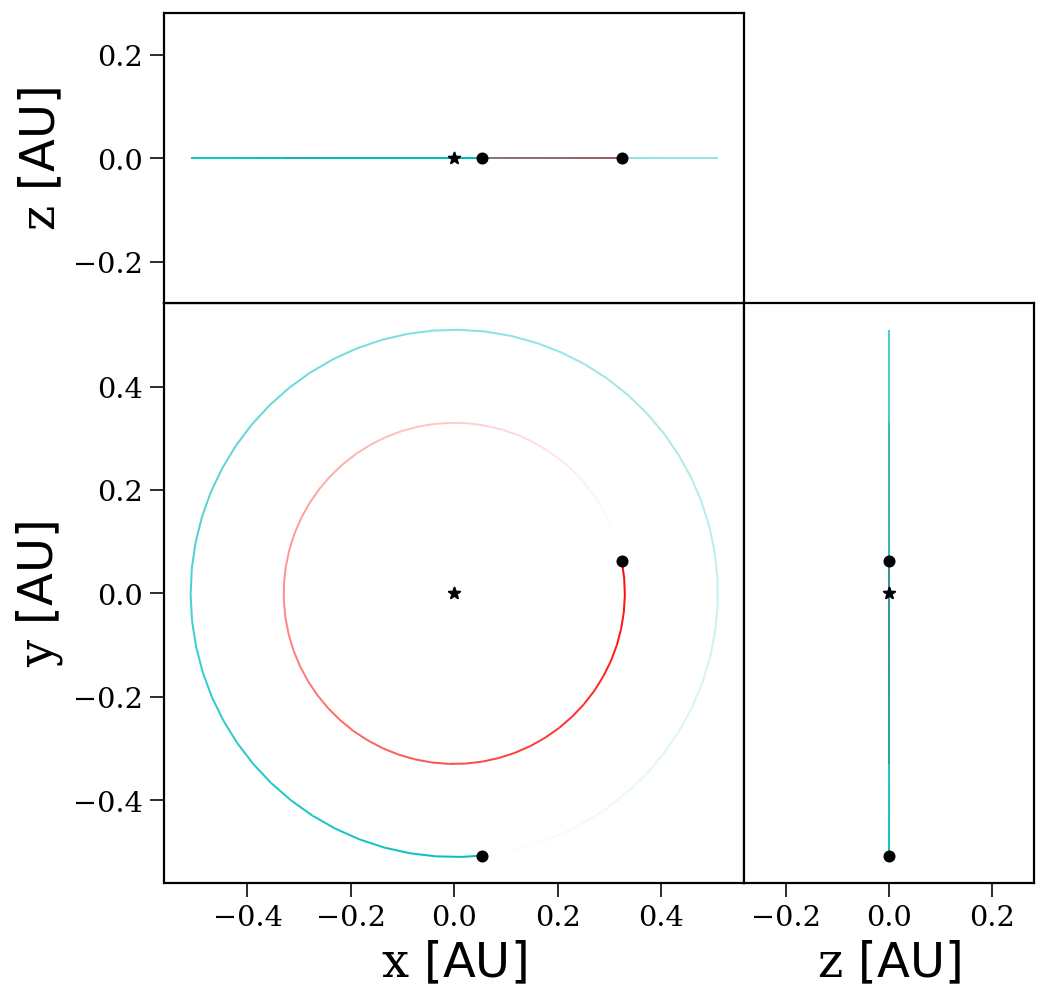

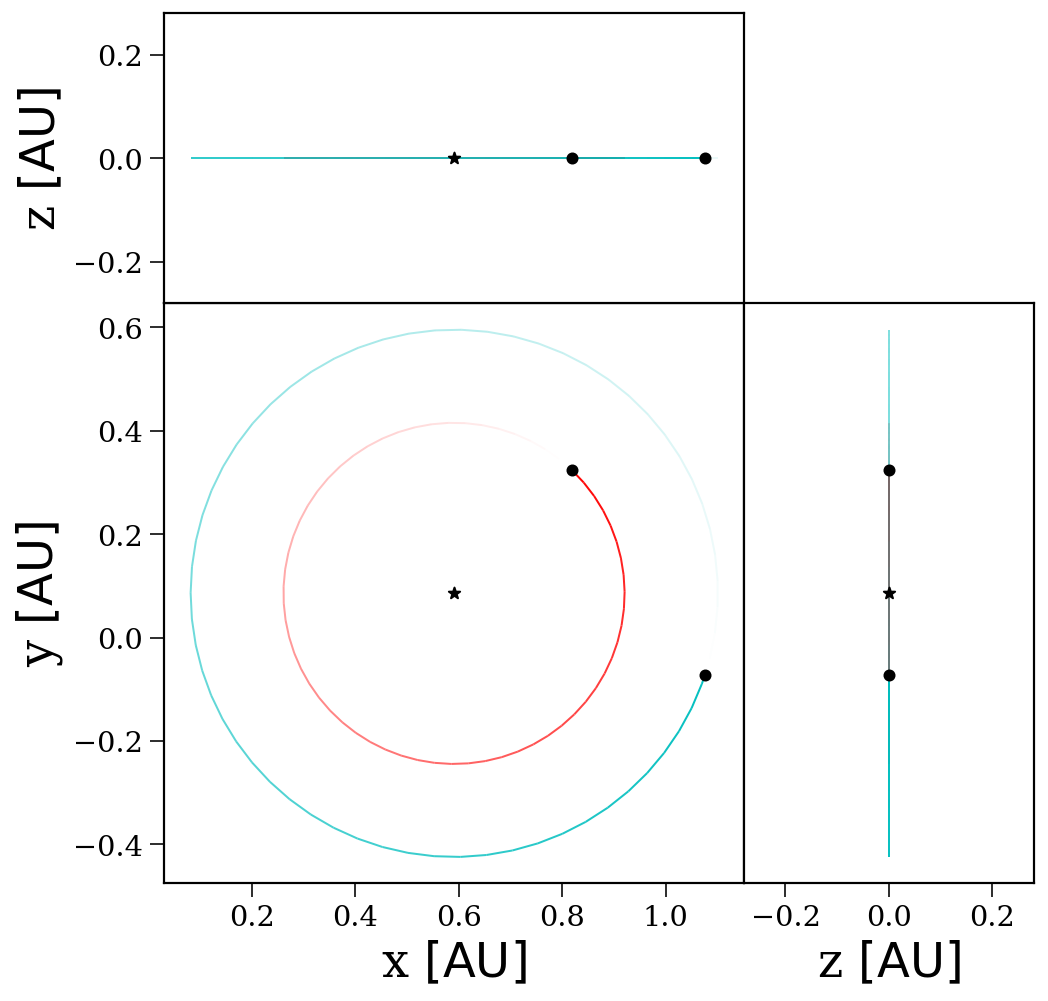

In [49]:
inc = 0
innermost_period = kepler289d["period"].to(u.yr).value

# settings
fancy = False
color = True

sim = rebound.Simulation()
sim.units = ("yr", "AU", "Msun")

for body in kepler289_system:
    if "a" not in body.keys():
        sim.add(m=body["mass"].to(u.Msun).value, r=body["radius"].to(u.AU).value)
    else:
        sim.add(m=body["mass"].to(u.Msun).value, r=body["radius"].to(u.AU).value, a=body["a"].to(u.AU).value,
                inc=inc, omega=np.random.uniform(0, 2 * np.pi))
        
fig, ax, _, _ = rebound.OrbitPlot(sim, unitlabel=r"$[\rm AU]$", color=color, fancy=fancy, slices=0.5)
sim.integrate(1000 * innermost_period)
rebound.OrbitPlot(sim, unitlabel=r"$[\rm AU]$", color=color, fancy=fancy, slices=0.5)

plt.show()